# High CO2 comparisons
In this notebook, we'll compare the results presented other papers that grew plants at elevated CO$_{2}$ to see if there is overlap in our dataset.

In [72]:
import pandas as pd
from os import listdir
import numpy as np
from upsetplot import from_contents, plot, UpSet
import warnings
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from plot_opposite_expression import plot_opposite_expression
from make_DEG_figure import makeDEGfigure
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
datapath = '../data/Araport11_outputs_ALL/deseq2_output/'
forty = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if '40' in name:
        forty[name] = pd.read_csv(datapath+f)

In [4]:
forty['1h_vs_7h_40o2_filtered'] = pd.read_csv('../data/Araport11_outputs_ALL/deseq2_filtered/40_o2_7h_v_1h_filtered.csv')

In [9]:
datapath = '../data/Araport11_outputs_ALL/deseq2_output/'
two = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if ('_2_' in name) or '2o2' in name:
        two[name] = pd.read_csv(datapath+f)

In [10]:
two['1h_vs_7h_2o2_filtered'] = pd.read_csv('../data/Araport11_outputs_ALL/deseq2_filtered/2_o2_7h_v_1h_filtered.csv')

## [Li et al 2008](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-3040.2008.01874.x)
From the methods:
> The plants in three plots (ambient air) experienced current CO$_{2}$ of 0.375 mg g$^{-1}$, while the plants in three CO$_{2}$ plots (elevated CO$_{2}$) were treated with CO$_{2}$ of 0.550 mg g$^{-1}$, simulating the expected environment in 2050

The interesting thing about this paper is that this experiment was carried out in the field, using the [UIUC SoyFACE system](https://soyface.illinois.edu/). The plants are surrounded by a ring that releases additional CO$_{2}$ over the plants, so they experience field conditions that are identical to the real world besides the CO$_{2}$ concentrations.

Because of this, their data were impacted by sampling date, as environmental conditions changed. All of the information is contained in their Supplemental Tabl 3, which we'll include here.

In [13]:
all_li = pd.read_excel('../data/external_data/pce_1874_sm_table_s3.xls', sheet_name=None)

In [14]:
new_cols = all_li['June 21 down'].loc[0].tolist()
new_cols[0] = 'gene_id'
all_li['June 21 down'].columns = new_cols

In [15]:
all_li['June 21 down'] = all_li['June 21 down'].drop(0)
all_li['June 21 down'].gene_id = all_li['June 21 down'].gene_id.str.upper()

In [16]:
for k, v in all_li.items():
    if k != 'June 21 down':
        v = v.rename(columns={'Unnamed: 0': 'gene_id'})
        v.gene_id = v.gene_id.str.upper()
        all_li[k] = v

Combine the up and down genes from each harvest day:

In [17]:
li_combined = {
    'june_21': pd.concat([all_li['June 21 down'], all_li['June 21 up']]),
    'june_27': pd.concat([all_li['June 27 down'], all_li['June 27 up']])
}

Now that we've wrangled the data, let's look for overlaps. All of these comparisons are for high CO$_{2}$ vs. ambient, which is comparable to our low oxygen condition. Before we compare these to our genes, let's look at how the two conditions overlap:

In [18]:
print(
    f'{len(set(li_combined["june_21"].gene_id.tolist()).intersection(set(li_combined["june_27"].gene_id.tolist())))} genes overlap between June 21 and June 27. '
    f'There are {len(li_combined["june_21"])} and {len(li_combined["june_27"])} genes in each of June 21 and June 27, respectively.'
)

6 genes overlap between June 21 and June 27. There are 512 and 312 genes in each of June 21 and June 27, respectively.


This is a very low number of genes; we'll look at both the dates separately for the purposes of this analysis.

In [19]:
for cond, df in two.items():
    for harvest, combined in li_combined.items():
        li_2 = df[df['gene_id'].isin(combined.gene_id)]
        if len(li_2) > 0:
            print(f'There are {len(li_2)} differentially expressed genes in common with condition {cond} at harvest date {harvest}')

There are 2 differentially expressed genes in common with condition 1h_o2_2_21 at harvest date june_21
There are 1 differentially expressed genes in common with condition 1h_o2_2_21 at harvest date june_27
There are 71 differentially expressed genes in common with condition 1h_vs_7h_2o2 at harvest date june_21
There are 41 differentially expressed genes in common with condition 1h_vs_7h_2o2 at harvest date june_27
There are 29 differentially expressed genes in common with condition 7h_o2_2_21 at harvest date june_21
There are 14 differentially expressed genes in common with condition 7h_o2_2_21 at harvest date june_27
There are 54 differentially expressed genes in common with condition 1h_vs_7h_2o2_filtered at harvest date june_21
There are 31 differentially expressed genes in common with condition 1h_vs_7h_2o2_filtered at harvest date june_27


That is a reasonable number of genes! How do the directions of expression compare?

In [20]:
both_dates = pd. merge(li_combined['june_21'], li_combined['june_27'], right_on='gene_id', left_on='gene_id', how='outer', suffixes=('_june_21', '_june_27'))
both_dates.head()

,gene_id,Category_june_21,ANN_june_21,Col 21 _june_21,CV21_june_21,Average_june_21,Fs.Pvalperm_june_21,Fs.adjPvalperm_june_21,Localization_june_21,Abbreviation_june_21,Category_june_27,ANN_june_27,Col 21 _june_27,CV21_june_27,Average_june_27,Fs.Pvalperm_june_27,Fs.adjPvalperm_june_27,Localization_june_27,Abbreviation_june_27
0,AT1G01820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cell division/organisation,peroxisomal biogenesis factor 11 family protei...,0.592756,0.597248,0.595002,0.000859,0.035438,Secretory,-
1,AT1G01840,unknown,unknown protein,-0.571419,-0.499497,-0.535458,0.000161,0.02546,Chloroplast,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT1G01960,signalling,EDA10 (embryo sac development arrest 10); guan...,0.408779,0.405168,0.406974,0.006541,0.047625,intracellular,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT1G02080,RNA metabolism/transcription,transcriptional regulator-related similar to ...,0.595438,0.679415,0.637427,0.002698,0.038341,nucleus,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT1G02190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,secondary metabolism,"CER1 protein, putative similar to CER1 protei...",-1.654848,-0.704452,-1.179650,0.001943,0.044020,-,-


In [21]:
for cond, df in two.items():
    merged = pd.merge(both_dates, df, how='inner', right_on='gene_id', left_on='gene_id')
    merged['same_dir_21_jun'] = merged['log2FoldChange']*merged['Col 21 _june_21'] > 0
    merged['same_dir_27_jun'] = merged['log2FoldChange']*merged['Col 21 _june_27'] > 0

    print(
        f'Of the {len(merged)} genes that appear in common between one of the harvest dates and condition {cond}, '
        f'{merged["same_dir_21_jun"].sum() + merged["same_dir_27_jun"].sum()} genes are expressed in the same '
        f'direction as condition {cond}.'
    )

Of the 3 genes that appear in common between one of the harvest dates and condition 1h_o2_2_21, 1 genes are expressed in the same direction as condition 1h_o2_2_21.
Of the 111 genes that appear in common between one of the harvest dates and condition 1h_vs_7h_2o2, 66 genes are expressed in the same direction as condition 1h_vs_7h_2o2.
Of the 42 genes that appear in common between one of the harvest dates and condition 7h_o2_2_21, 34 genes are expressed in the same direction as condition 7h_o2_2_21.
Of the 84 genes that appear in common between one of the harvest dates and condition 1h_vs_7h_2o2_filtered, 50 genes are expressed in the same direction as condition 1h_vs_7h_2o2_filtered.


Hey that's not bad! We're looking at ~2/3rds of the in-common genes being differentially expressed in the same direction under high CO$_{2}$. While they didn't test any low CO$_{2}$ conditions, do any of these also appear in our 40% condition? We want to narrow down as much as possible what we think may be interesting here.

In [22]:
for cond, df in forty.items():
    merged = pd.merge(both_dates, df, how='inner', right_on='gene_id', left_on='gene_id')
    merged['same_dir_21_jun'] = merged['log2FoldChange']*merged['Col 21 _june_21'] > 0
    merged['same_dir_27_jun'] = merged['log2FoldChange']*merged['Col 21 _june_27'] > 0

    print(
        f'Of the {len(merged)} genes that appear in common between one of the harvest dates and condition {cond}, '
        f'{merged["same_dir_21_jun"].sum() + merged["same_dir_27_jun"].sum()} genes are expressed in the same '
        f'direction as condition {cond}.'
    )

Of the 8 genes that appear in common between one of the harvest dates and condition 1h_o2_40_21, 5 genes are expressed in the same direction as condition 1h_o2_40_21.
Of the 2 genes that appear in common between one of the harvest dates and condition 7h_o2_40_21, 1 genes are expressed in the same direction as condition 7h_o2_40_21.
Of the 90 genes that appear in common between one of the harvest dates and condition 1h_vs_7h_40o2, 31 genes are expressed in the same direction as condition 1h_vs_7h_40o2.
Of the 57 genes that appear in common between one of the harvest dates and condition 1h_vs_7h_40o2_filtered, 14 genes are expressed in the same direction as condition 1h_vs_7h_40o2_filtered.


There are many fewer genes that appear in our 40% condition, and only about 1/3rd are expressed in the same direction. I want to know if there is an overlap between the genes that appear in our 2% vs. 40% from the combined harvest dates, we will do this as an upset plot to make visualization easier. This will be very visually overwhelming because there are small overlaps among all these conditions we care about; let's outline the columns that contain genes from this paper in red so that it's easier to look at. Let's alo drop the non-filtered time comparisons and separate time from oxygen.

In [23]:
genes_time = {k: v.gene_id.tolist() for k, v in li_combined.items()}
genes_time.update({k: v.gene_id.tolist() for k, v in two.items() if k in ['1h_vs_7h_2o2_filtered']})
genes_time.update({k: v.gene_id.tolist() for k, v in forty.items() if k in ['1h_vs_7h_40o2_filtered']})

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

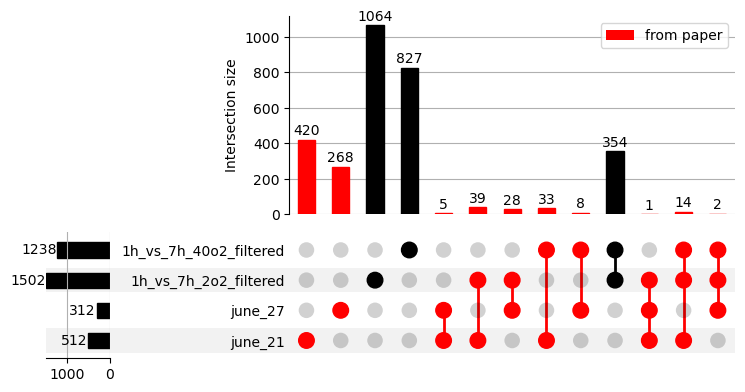

In [24]:
warnings.filterwarnings('ignore') 
to_plot_time = from_contents(genes_time)
upset = UpSet(to_plot_time, show_counts=True, sort_categories_by='input')
for c in ['june_21', 'june_27']:
    upset.style_subsets(present=c, facecolor='red', label='from paper')
upset.plot()

In [25]:
two.keys()

dict_keys(['1h_o2_2_21', '1h_vs_7h_2o2', '7h_o2_2_21', '1h_vs_7h_2o2_filtered'])

In [26]:
genes_o2 = {k: v.gene_id.tolist() for k, v in li_combined.items()}
genes_o2.update({k: v.gene_id.tolist() for k, v in two.items() if k in ['1h_o2_2_21', '7h_o2_2_21']})
genes_o2.update({k: v.gene_id.tolist() for k, v in forty.items() if k in ['1h_o2_40_21', '7h_o2_40_21']})

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

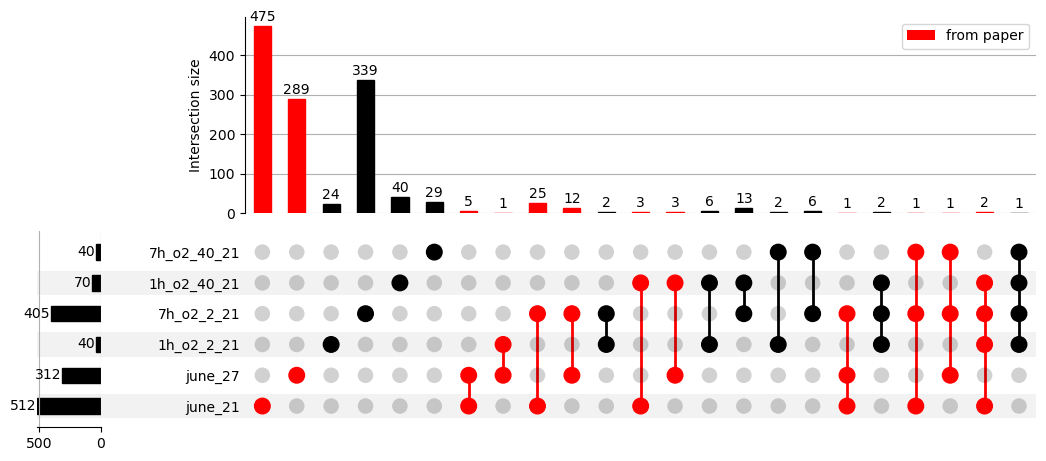

In [27]:
warnings.filterwarnings('ignore') 
to_plot_o2 = from_contents(genes_o2)
upset = UpSet(to_plot_o2, show_counts=True, sort_categories_by='input')
for c in ['june_21', 'june_27']:
    upset.style_subsets(present=c, facecolor='red', label='from paper')
upset.plot()

The points of "concern", so to say, are columns where a circle is filled in for more than one of our experimental conditions as well as one or more of the paper conditions. These are the last three columns in the top plot, and the 2nd to 4th last last columns in the second plot. The numbers in these columns in the second plot are vanishingly small; however, in the top plot we see that 14 genes from the June 21 harvest date overlap in both our conditions. However, these comparisons don't account for the direction of expression change in the condition. If those 14 genes were to be oppositely expressed in our two conditions, it could prove interesting. Let's use our arrow visualization for the genes in the multiple overlaps.

In [52]:
# Get the genes we want to plot
time_overlaps = to_plot_time.reset_index()
time_to_check = pd.concat(
    [time_overlaps[time_overlaps['june_21'] & time_overlaps['1h_vs_7h_2o2_filtered'] & time_overlaps['1h_vs_7h_40o2_filtered']], 
    time_overlaps[time_overlaps['june_27'] & time_overlaps['1h_vs_7h_2o2_filtered'] & time_overlaps['1h_vs_7h_40o2_filtered']]]
).id.tolist()

In [53]:
# Combine their log2FC values to be able to plot them
both_dates_logfc = both_dates[['gene_id', 'Col 21 _june_21', 'Col 21 _june_27']]
both_dates_logfc = both_dates_logfc.rename(columns={'Col 21 _june_21': 'log2FoldChange_june_21', 'Col 21 _june_27': 'log2FoldChange_june_27'})
both_dates_logfc[both_dates_logfc['gene_id'].isin(time_to_check)]

time_all_log2fc = pd.merge(both_dates_logfc, two['1h_vs_7h_2o2_filtered'][['gene_id', 'log2FoldChange']], left_on='gene_id', right_on='gene_id')
time_all_log2fc = pd.merge(time_all_log2fc, forty['1h_vs_7h_40o2_filtered'][['gene_id', 'log2FoldChange']], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
time_all_log2fc

,gene_id,log2FoldChange_june_21,log2FoldChange_june_27,log2FoldChange_2o2,log2FoldChange_40o2
0,AT1G02405,0.444711,NaN,-2.694110,-2.946572
1,AT1G13245,-0.458311,NaN,-2.338373,-1.963033
2,AT1G63900,-0.547663,NaN,-1.650795,-2.747970
3,AT2G22125,0.780402,NaN,-1.688551,-1.757001
4,AT2G25080,-0.640328,NaN,-1.413174,-2.031515
5,AT2G36460,NaN,0.575586,1.604984,1.648564
6,AT3G24550,0.387943,NaN,-2.194526,-2.000229
7,AT4G04955,0.637167,NaN,-2.440039,-1.730762
8,AT5G01730,0.602487,NaN,-3.006104,-1.852998
9,AT5G14740,-0.652499,NaN,-2.608731,1.481046


In [54]:
ara = pd.read_csv('../data/external_data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k: v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}

In [55]:
time_cols = {
    'DE at 2%': 'log2FoldChange_2o2',
    'DE at 40%': 'log2FoldChange_40o2',
    'DE on June 21': 'log2FoldChange_june_21',
    'DE on June 27': 'log2FoldChange_june_27'
}

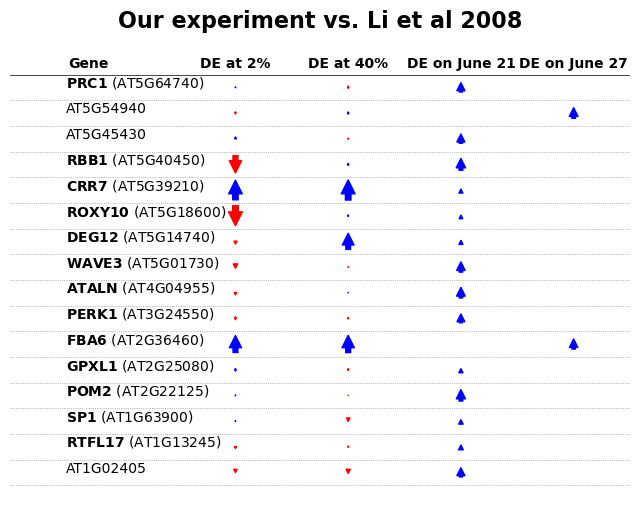

In [62]:
plot_opposite_expression(
    time_all_log2fc,
    time_cols,
    tair2gene,
    normalize=True,
    title='Our experiment vs. Li et al 2008',
    scale_factor=20
)

Now let's do the other condition:

In [45]:
# Get the genes we want to plot
o2_overlaps = to_plot_o2.reset_index()
o2_to_check = pd.concat(
    [o2_overlaps[o2_overlaps['june_21'] & o2_overlaps['7h_o2_2_21'] & o2_overlaps['7h_o2_40_21']],
     o2_overlaps[o2_overlaps['june_27'] & o2_overlaps['7h_o2_2_21'] & o2_overlaps['7h_o2_40_21']],
    o2_overlaps[o2_overlaps['june_21'] & o2_overlaps['7h_o2_2_21'] & o2_overlaps['1h_o2_2_21'] & o2_overlaps['1h_o2_40_21']]]
).id.tolist()

In [46]:
# Combine their log2FC values to be able to plot them
both_dates_logfc = both_dates[['gene_id', 'Col 21 _june_21', 'Col 21 _june_27']]
both_dates_logfc = both_dates_logfc.rename(columns={'Col 21 _june_21': 'log2FoldChange_june_21', 'Col 21 _june_27': 'log2FoldChange_june_27'})
to_keep = both_dates_logfc[both_dates_logfc['gene_id'].isin(o2_to_check)]

o2_all_log2fc = pd.merge(to_keep, two['1h_o2_2_21'][['gene_id', 'log2FoldChange']], left_on='gene_id', right_on='gene_id', how='left')
o2_all_log2fc = pd.merge(o2_all_log2fc, forty['7h_o2_40_21'][['gene_id', 'log2FoldChange']], left_on='gene_id', right_on='gene_id', suffixes=('_2o2_1h', '_40o2_7h'), how='left')
o2_all_log2fc = pd.merge(o2_all_log2fc, two['7h_o2_2_21'][['gene_id', 'log2FoldChange']], left_on='gene_id', right_on='gene_id', suffixes=('', '_2o2_7h'), how='left')
o2_all_log2fc

,gene_id,log2FoldChange_june_21,log2FoldChange_june_27,log2FoldChange_2o2_1h,log2FoldChange_40o2_7h,log2FoldChange
0,AT1G02205,NaN,-0.889631,NaN,-2.053616,-2.710259
1,AT1G56650,0.786379,NaN,NaN,-2.706680,4.347003
2,AT1G61800,1.330659,NaN,1.652439,NaN,5.027641
3,AT3G02040,0.491168,NaN,-2.402810,NaN,4.894077


In [47]:
o2_cols = {
    '1h/2%': 'log2FoldChange_2o2_1h',
    '7h/2%': 'log2FoldChange',
    '7h/40%': 'log2FoldChange_40o2_7h',
    'June 21': 'log2FoldChange_june_21',
    'June 27': 'log2FoldChange_june_27'
}

In [48]:
o2_all_log2fc

,gene_id,log2FoldChange_june_21,log2FoldChange_june_27,log2FoldChange_2o2_1h,log2FoldChange_40o2_7h,log2FoldChange
0,AT1G02205,NaN,-0.889631,NaN,-2.053616,-2.710259
1,AT1G56650,0.786379,NaN,NaN,-2.706680,4.347003
2,AT1G61800,1.330659,NaN,1.652439,NaN,5.027641
3,AT3G02040,0.491168,NaN,-2.402810,NaN,4.894077


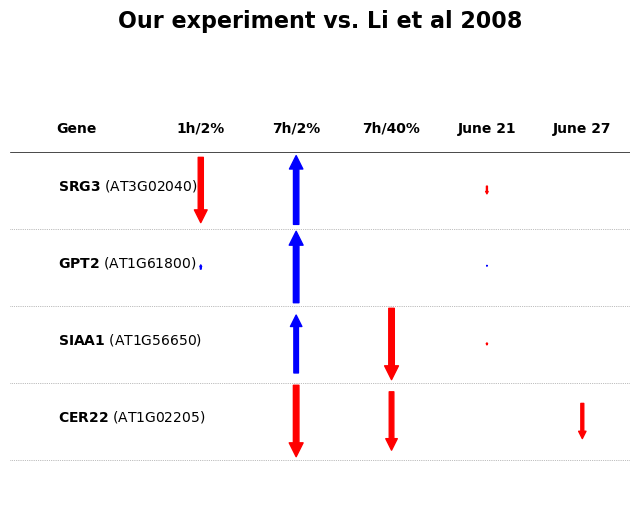

In [61]:
plot_opposite_expression(
    o2_all_log2fc,
    o2_cols,
    tair2gene,
    normalize=True,
    title='Our experiment vs. Li et al 2008',
    scale_factor=20
)

Let's also make the known gene expression plot on the June 21 and June 27 samples to see if that can clarify what's going on:

In [64]:
help(makeDEGfigure)

Help on function makeDEGfigure in module make_DEG_figure:

makeDEGfigure(deg_dfs, photosynth_sets, photosynth_colors, semantic_names, tair2gene, id_col='gene_id', title_name='genes', show_all_x=True, separate_columns=False)
    Maked stacked expresion figure.
    
    parameters:
        deg_dfs, dict: keys are comparison names, values are dfs with
            log2FC values for significant DEGs
        photosynth_sets, dict: keys are set names, values are lists of
            gene names
        photosynth_colors, dict: keys are photosynth gene categories,
            values are colors to use
        semantic_names, dict: keys are the keys of deg_dfs, values are
            semantic names to be used as subplot titles
        tair2gene, dict: keys are lwoercased TAIR ID's of the genes in the
            plot, values are the gene names
        id_col, str: name of the column with the gene IDs
        show_all_x, bool: whether or not to put tick labels on all subplots
        separate_colu

In [70]:
for k, df in li_combined.items():
    df['log2FoldChange'] = df['Col 21 '] # Not the trailing whitespace lolol https://xkcd.com/2109/
    li_combined[k] = df

In [78]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes_unique.json') as f:
    all_photosynth_genes = json.load(f)
legend_semantic = {
    'plastidCut2': 'PlastidCut 2',
    'carb_met': 'Carbohydrate metabolism',
    'lipids': 'Lipid metabolism',
    'light_rxns': 'Light reactions',
    'photorespiration': 'Photorespiration',
    'ros_genes': 'ROS'
}
all_photosynth_genes = {legend_semantic[k]: v for k, v in all_photosynth_genes.items()}

In [79]:
ara = pd.read_csv('../data/external_data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k.lower(): v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}
semantic_names = {
    'june_21': 'June 21',
    'june_27': 'June 27'
}
photosynth_colors = {'PlastidCut 2': 'springgreen', 'Carbohydrate metabolism': 'wheat', 'Lipid metabolism': 'mediumslateblue', 'Light reactions': 'yellow', 'Photorespiration': 'mediumorchid', 'ROS': 'lightskyblue'}

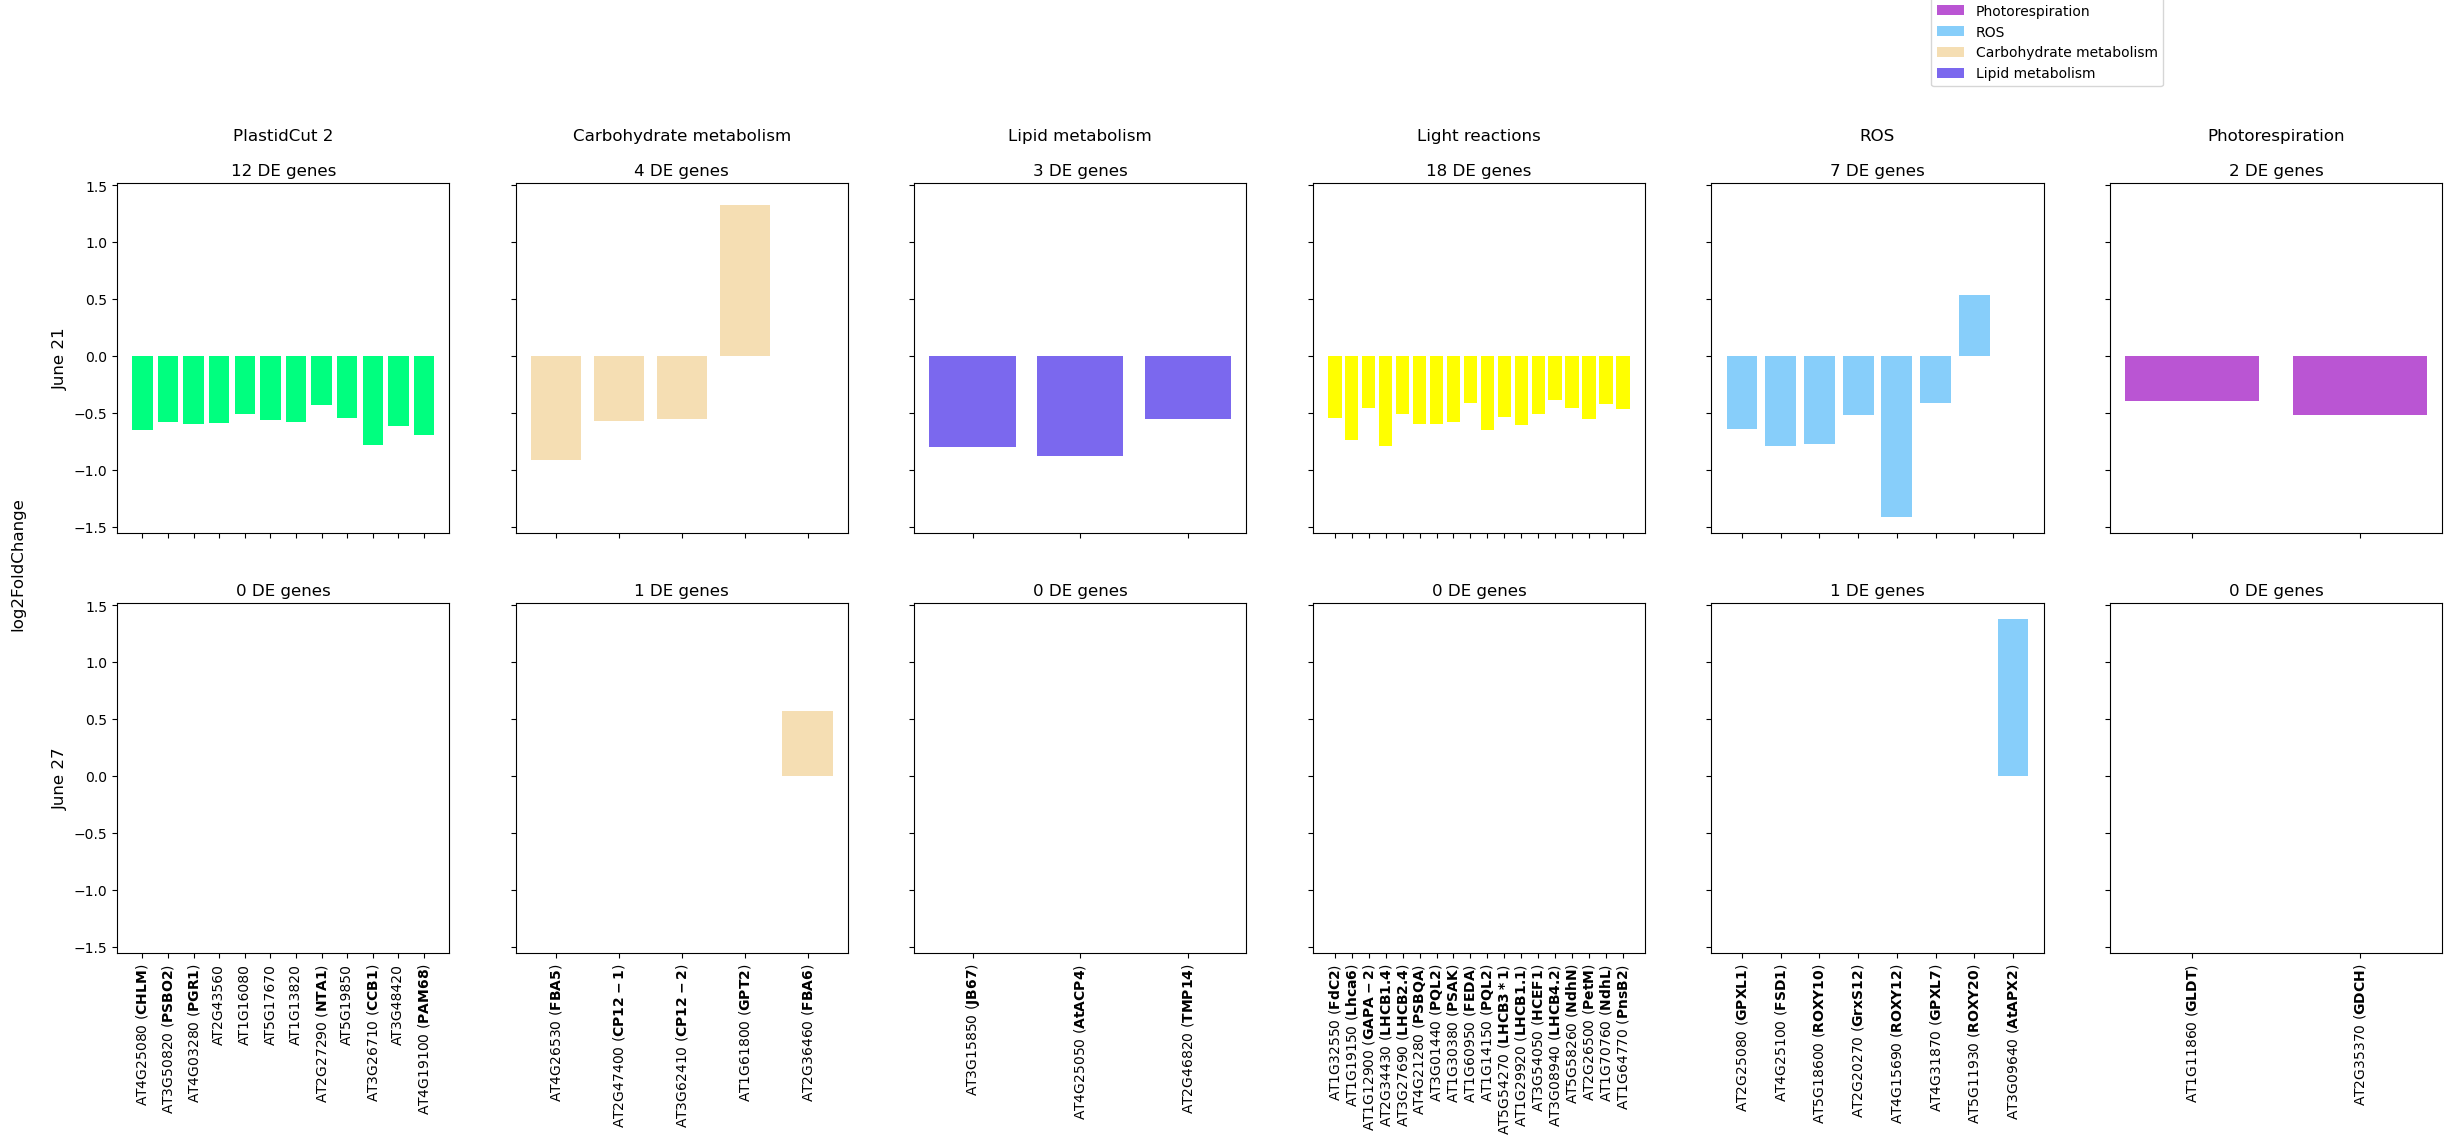

In [80]:
makeDEGfigure(li_combined, all_photosynth_genes, photosynth_colors, semantic_names, tair2gene, show_all_x=False, separate_columns=True)

It's wild how much the weather change over a single week impacted the results!